# Hacklytics 2021
Anusha, Edward, Pravallika, Safia

# Import Required Tools

In [29]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import scipy.stats as stats
import sklearn
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

# Project Outline by High-level Functions
May need several low-level functions for each high-level function

## Import data

In [30]:
def import_dataframes(country="US", country_lower="us"):
    """Imports dataframes for specified country, will filter out rows unrelated to country
    url = "https://raw.githubusercontent.com/SafiaKhaleel/Hacklytics2021/main"
    """
    url_prefix = "https://raw.githubusercontent.com/SafiaKhaleel/Hacklytics2021/main/Region_Mobility_Report_CSVs/2020_"
    url_suffix = "_Region_Mobility_Report.csv"
    url = url_prefix + country + url_suffix
    mobility_df = pd.read_csv(url)
    
    url_prefix = "https://raw.githubusercontent.com/SafiaKhaleel/Hacklytics2021/main/Covid_Data/RAW_"
    url_suffix = "_confirmed_cases.csv"
    url = url_prefix + country_lower + url_suffix
    covid_cases_df = pd.read_csv(url)
    
    url_prefix = "https://raw.githubusercontent.com/SafiaKhaleel/Hacklytics2021/main/Covid_Data/RAW_"
    url_suffix = "_deaths.csv"
    url = url_prefix + country_lower + url_suffix
    covid_death_df = pd.read_csv(url)
    
    
    display(mobility_df.head())
    display(covid_cases_df.head())
    display(covid_death_df.head())
    return mobility_df, covid_cases_df, covid_death_df

In [31]:
mobility_df,covid_cases_df,covid_death_df = import_dataframes()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
2,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
3,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
4,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0


,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4029,4065,4105,4164,4190,4239,4268,4305,4336,4546,4645,4705,4770,4847,4879,4902,4970,4998,5075,5103,5154,5184,5198,5227,5257,5270,5327,5358,5376,5407,5440,5499,5554,5596,5596,5669,5683,5723,5753,5811
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12825,12962,13172,13392,13601,13823,13955,14064,14187,14440,14656,14845,15052,15202,15327,15417,15572,15701,15841,16002,16176,16251,16346,16513,16653,16798,16981,17128,17256,17333,17496,17629,17779,17922,17922,18126,18211,18344,18418,18494
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1406,1417,1462,1492,1514,1517,1528,1530,1533,1575,1597,1614,1634,1648,1658,1663,1679,1685,1696,1712,1723,1729,1730,1738,1760,1778,1793,1805,1827,1834,1882,1898,1920,1931,1931,1951,1956,1966,1981,1989
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1746,1762,1792,1817,1834,1854,1863,1882,1885,1923,1944,1981,2015,2038,2051,2060,2090,2109,2113,2130,2144,2151,2162,2170,2188,2198,2212,2223,2223,2229,2247,2261,2271,2284,2284,2307,2309,2319,2321,2327
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4465,4483,4535,4584,4641,4693,4729,4746,4771,4849,4898,4957,5018,5047,5066,5080,5134,5170,5219,5264,5292,5304,5308,5320,5376,5411,5439,5462,5473,5485,5517,5568,5612,5655,5655,5713,5720,5745,5768,5842


,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,"Autauga, Alabama, US",55869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,47,47,47,48,48,50,50,50,50,50,50,50,50,53,54,55,55,55,55,55,55,55,55,55,55,61,61,62,62,62,65,67,69,69,69,69,69,70,71,74
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,"Baldwin, Alabama, US",223234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,152,152,156,160,161,169,169,169,169,169,171,171,171,173,173,173,175,175,177,179,182,182,182,183,184,188,188,189,189,189,216,217,225,224,224,224,224,228,228,233
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,"Barbour, Alabama, US",24686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,32,32,32,32,32,33,33,33,33,33,35,35,35,35,35,35,35,35,36,36,36,36,36,36,36,36,37,38,38,38,40,40,40,40,40,40,40,40,42,43
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,"Bibb, Alabama, US",22394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,42,42,42,46,46,46,46,46,46,46,48,48,48,48,48,48,48,48,47,47,47,47,47,47,47,48,48,48,48,48,51,51,51,51,51,52,52,52,52,52
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,"Blount, Alabama, US",57826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,58,58,58,63,63,63,63,63,63,63,67,72,75,77,77,77,79,80,80,83,83,83,83,83,83,86,86,86,86,86,94,95,98,98,98,100,100,101,105,109


## Preprocess data

In [32]:
def preprocess_mobility_df(mobility_df, minimum_data=300):
    """Takes the raw mobility dataframe and does the following:
    
    -Removes rows will null mobility data
    
    -Removes counties with insufficient data (<minimum_data)
    
    -Returns clean data with the following columns (renamed): state,county,date,6 mobility columns
    
    -May need to aggregate by states if covid_df does not provide county information
    """
    #display(mobility_df.isnull().sum())
    clean_mobility_df = mobility_df.copy()

    """A lot of values seem to be missing. 
After exploring the data manually, it appears that there are many counties with incomplete data.
Let us focus on the counties that have complete data. 
To do this, we drop the rows with incomplete data."""

    places = ['retail_and_recreation','grocery_and_pharmacy','parks','transit_stations','workplaces','residential']
    places_percent_change = [place + '_percent_change_from_baseline' for place in places]
    clean_mobility_df = mobility_df.dropna(axis = 0, subset = places_percent_change)
    #print(clean_country_df.isnull().sum())

    #See which counties have enough entries

    county_grouped_df = clean_mobility_df.groupby(['sub_region_1','sub_region_2'], as_index=False).count().reset_index()
    #display(county_grouped_df['date'])
    state_county_pair = county_grouped_df[['sub_region_1', 'sub_region_2']][county_grouped_df['date']>minimum_data]
    #display(state_county_pair)

    merged = clean_mobility_df.merge(state_county_pair, how='outer', indicator=True)
    merged[merged['_merge'] =='both'].index
    clean_mobility_df = clean_mobility_df[(merged['_merge'] =='both').values]
    #clean_country_df = clean_country_df[clean_country_df['sub_region_2'] in state_county_pair.]
    
    # Drop columns
    clean_mobility_df.drop(['metro_area', 'iso_3166_2_code','census_fips_code','country_region_code','country_region'] ,axis = 1, inplace=True)
    #clean_country_df.rename(columns={"	sub_region_1": "State", "	sub_region_2": "County"})
    
    #Rename columns
    clean_mobility_df.rename(columns={"sub_region_1": "State", "sub_region_2": "County", 'date':'Date'},inplace = True)
    clean_mobility_df['County'] = clean_mobility_df['County'].str.replace('County', '')
    clean_mobility_df['Date']= pd.to_datetime(clean_mobility_df['Date'])
    
    display(clean_mobility_df.head())
    return clean_mobility_df

In [33]:
clean_mobility_df = preprocess_mobility_df(mobility_df)

,State,County,Date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
1050,Alabama,Baldwin,2020-02-15,17.0,12.0,55.0,8.0,6.0,-2.0
1051,Alabama,Baldwin,2020-02-16,8.0,8.0,-12.0,7.0,-3.0,2.0
1052,Alabama,Baldwin,2020-02-17,9.0,9.0,31.0,7.0,-3.0,1.0
1053,Alabama,Baldwin,2020-02-18,7.0,8.0,21.0,0.0,2.0,0.0
1054,Alabama,Baldwin,2020-02-19,12.0,9.0,41.0,8.0,3.0,-1.0


In [34]:
def preprocess_covid_df(covid_cases_df, covid_death_df):
    """Takes the raw covid cases/death info dataframe and does the following:
    
    -Returns clean data with the at least the following columns (renamed): state,county,date,cases
    
    Not currently using the below information regarding government data
    Not sure yet what needs to be done, this dataset is very interesting, some useful columns are:
        date_announced, date_start, date_end, description, country, province, type
        
    Sadly there is no county level data
    
    type: restrictions on mass gatherings, external border restrictions, restriction and regulation of business,
        closure and regulation of schools, health resources.
        
    could try to use this to model mobility response to government policies: such as panic buying,
        compliance of stay-at-home orders, travel before lock-down etc
    could try to use this to model covid case/death response to government policies and mobility
    
    """
    clean_covid_cases_df = covid_cases_df.copy()
    clean_covid_death_df = covid_death_df.copy()
    
    clean_covid_cases_df.drop(['UID','iso2','iso3','code3','FIPS','Country_Region','Lat','Long_','Combined_Key'], axis = 1, inplace = True)
    clean_covid_cases_df.rename(columns={"Province_State": "State", "Admin2": "County", 'date':'Date'},inplace = True)
    clean_covid_cases_df.dropna(axis = 0,inplace=True,how ='any')
    clean_covid_death_df.drop(['UID','iso2','iso3','code3','FIPS','Country_Region','Lat','Long_','Combined_Key','Population'], axis = 1, inplace = True)
    clean_covid_death_df.rename(columns={"Province_State": "State", "Admin2": "County", 'date':'Date'},inplace = True)
    clean_covid_cases_df.dropna(axis = 0,inplace=True,how ='any')

    clean_covid_cases_df = clean_covid_cases_df.melt(id_vars=["State", "County"], 
        var_name="Date", 
        value_name="Cases")
    clean_covid_death_df = clean_covid_death_df.melt(id_vars=["State", "County"], 
        var_name="Date", 
        value_name="Death")
    clean_covid_cases_df['Date']= pd.to_datetime(clean_covid_cases_df['Date'])
    clean_covid_death_df['Date']= pd.to_datetime(clean_covid_death_df['Date'])

    display(clean_covid_cases_df.head())
    display(clean_covid_death_df.head())
    return clean_covid_cases_df, clean_covid_death_df

In [35]:
clean_covid_cases_df, clean_covid_death_df = preprocess_covid_df(covid_cases_df, covid_death_df)

,State,County,Date,Cases
0,Alabama,Autauga,2020-01-22,0
1,Alabama,Baldwin,2020-01-22,0
2,Alabama,Barbour,2020-01-22,0
3,Alabama,Bibb,2020-01-22,0
4,Alabama,Blount,2020-01-22,0


,State,County,Date,Death
0,Alabama,Autauga,2020-01-22,0
1,Alabama,Baldwin,2020-01-22,0
2,Alabama,Barbour,2020-01-22,0
3,Alabama,Bibb,2020-01-22,0
4,Alabama,Blount,2020-01-22,0


## Merge data

In [36]:
def merge_dataframes(clean_mobility_df, clean_covid_cases_df, clean_covid_death_df):
    """Combines the three dataframes we have. Inner join by columns state, county(if possible) and date."""
    merged_df=pd.merge(pd.merge(clean_covid_cases_df,clean_covid_death_df, on =['State','County','Date']),clean_mobility_df,how ='inner',on =['State','County','Date'])
    merged_df['Date']= pd.to_datetime(merged_df['Date'])
    display(merged_df.head())
    return merged_df

In [37]:
merged_df = merge_dataframes(clean_mobility_df,clean_covid_cases_df,clean_covid_death_df)

,State,County,Date,Cases,Death,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Alaska,Anchorage,2020-02-15,0,0,5.0,3.0,11.0,3.0,0.0,0.0
1,Maryland,Baltimore,2020-02-15,0,0,2.0,-2.0,4.0,-1.0,0.0,0.0
2,Missouri,St. Louis,2020-02-15,0,0,9.0,5.0,15.0,5.0,2.0,0.0
3,Virginia,Newport News,2020-02-15,0,0,1.0,0.0,14.0,-3.0,0.0,-1.0
4,Virginia,Norfolk,2020-02-15,0,0,1.0,1.0,1.0,-2.0,-2.0,0.0


## Visualize merged data

In [38]:
def plot_merged_df(merged_df,county='all',state=""):
    """Plots a time series of mobility, cases and deaths using subplot
    x-axis: time
    y-axis: mobility/cases/death
    if possible include vertical lines when new policies announced/in-effect
    """
    cols = None
    if county=='all':
        merged_df.plot(x='Date',y=cols, subplots=True, kind='line')
    else:
        merged_df[(merged_df['State']==state) & (merged_df['County']==county)].plot(x='Date',y=cols, subplots=True, kind='line')
    return None

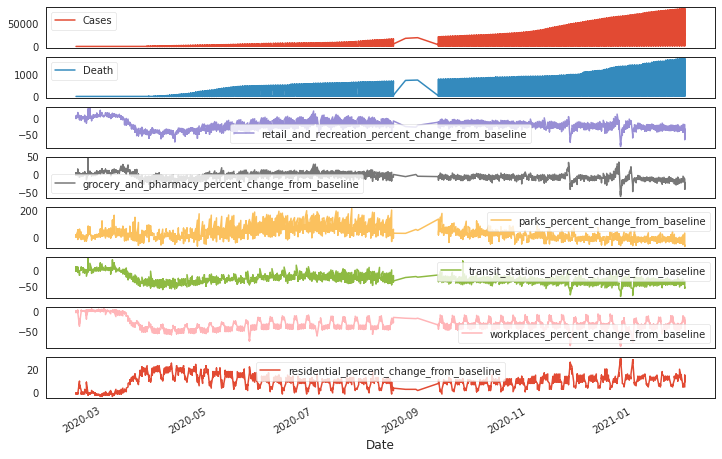

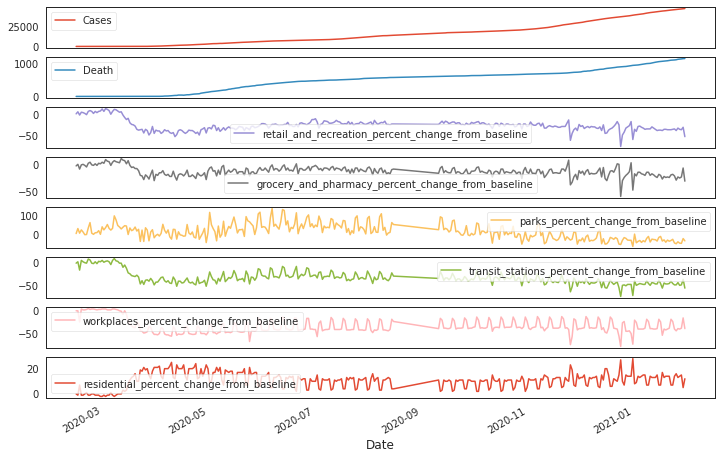

In [39]:
plot_merged_df(merged_df)
plot_merged_df(merged_df,'Baltimore','Maryland')

In [40]:
merged_df[merged_df['County']=='Baltimore'][150:200]

,State,County,Date,Cases,Death,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
1029,Maryland,Baltimore,2020-07-14,8990,498,-14.0,-6.0,59.0,-31.0,-42.0,10.0
1036,Maryland,Baltimore,2020-07-15,9153,502,-17.0,-7.0,50.0,-31.0,-42.0,11.0
1043,Maryland,Baltimore,2020-07-16,9261,504,-18.0,-8.0,44.0,-33.0,-42.0,11.0
1050,Maryland,Baltimore,2020-07-17,9376,505,-22.0,-11.0,33.0,-32.0,-41.0,12.0
1057,Maryland,Baltimore,2020-07-18,9517,509,-23.0,-6.0,72.0,-21.0,-17.0,4.0
1064,Maryland,Baltimore,2020-07-19,9723,510,-22.0,-4.0,70.0,-25.0,-22.0,4.0
1071,Maryland,Baltimore,2020-07-20,9828,512,-23.0,-13.0,10.0,-39.0,-43.0,13.0
1078,Maryland,Baltimore,2020-07-21,9994,517,-17.0,-9.0,30.0,-36.0,-43.0,11.0
1085,Maryland,Baltimore,2020-07-22,10153,519,-24.0,-16.0,-2.0,-39.0,-43.0,13.0
1092,Maryland,Baltimore,2020-07-23,10345,520,-19.0,-8.0,19.0,-36.0,-42.0,12.0


There appears to be a gap between August 15 to September 11 with no data. Hence we will partition the dataset into two, based on before August 15 and after September 11

In [41]:
cutoff1 = pd.Timestamp(year=2020, month=8, day=15)
cutoff2 = pd.Timestamp(year=2020, month=9, day=11)
merged_df1 = merged_df[merged_df['Date']<=cutoff1]
merged_df2 = merged_df[merged_df['Date']>=cutoff2]
print(cutoff1.weekofyear)
print(cutoff2.weekofyear)
merged_df1.sort_values(['Date'])
merged_df2.sort_values(['Date'])
display(merged_df1.tail())
display(merged_df2.tail())

33
37


,State,County,Date,Cases,Death,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
1247,Missouri,St. Louis,2020-08-15,16409,678,-29.0,-2.0,51.0,-21.0,-19.0,3.0
1248,Virginia,Newport News,2020-08-15,1960,20,-29.0,-16.0,-27.0,-46.0,-21.0,7.0
1249,Virginia,Norfolk,2020-08-15,3944,34,-28.0,-8.0,0.0,-20.0,-19.0,6.0
1250,Virginia,Richmond,2020-08-15,323,4,-44.0,-18.0,-33.0,-42.0,-30.0,9.0
1251,Virginia,Virginia Beach,2020-08-15,5322,55,-15.0,-5.0,17.0,-35.0,-16.0,6.0


,State,County,Date,Cases,Death,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
2257,Missouri,St. Louis,2021-01-31,83508,1686,-36.0,-14.0,-51.0,-39.0,-17.0,7.0
2258,Virginia,Newport News,2021-01-31,9772,97,-40.0,-30.0,-70.0,-50.0,-20.0,9.0
2259,Virginia,Norfolk,2021-01-31,12850,142,-39.0,-23.0,-48.0,-39.0,-21.0,9.0
2260,Virginia,Richmond,2021-01-31,1220,7,-67.0,-42.0,-42.0,-57.0,-51.0,15.0
2261,Virginia,Virginia Beach,2021-01-31,26211,206,-32.0,-22.0,-59.0,-53.0,-20.0,9.0


## Group into weekly buckets

In [42]:
def group_weekly(merged_df):
    """ Groups values by week of year
    """
    # calculate the windows, gives a unique number per entry associating it to its respective window
    windows = (merged_df.Date.apply(lambda x: x.weekofyear + 53*(x.year-2020)*(x.weekofyear!=53)))
    # group by these windows and compute the value mean
    weekly_df = merged_df.groupby([windows, 'State', 'County']).mean().reset_index()
    display(weekly_df)
    return weekly_df

In [43]:
weekly_df = group_weekly(merged_df)

,Date,State,County,Cases,Death,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,7,Alaska,Anchorage,0.000000,0.000000,10.000000,3.000000,27.000000,4.500000,1.500000,-0.500000
1,7,Maryland,Baltimore,0.000000,0.000000,4.500000,-0.500000,17.000000,0.500000,0.000000,-0.500000
2,7,Missouri,St. Louis,0.000000,0.000000,14.500000,10.000000,34.500000,7.500000,3.000000,-0.500000
3,7,Virginia,Newport News,0.000000,0.000000,2.500000,0.500000,-2.000000,-5.000000,1.000000,-1.000000
4,7,Virginia,Norfolk,0.000000,0.000000,2.500000,0.500000,-4.000000,-3.000000,-2.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
333,57,Missouri,St. Louis,82555.285714,1667.857143,-36.428571,-20.142857,-37.714286,-36.142857,-29.857143,11.428571
334,57,Virginia,Newport News,9474.285714,89.000000,-26.428571,-17.571429,-30.714286,-38.000000,-27.285714,10.857143
335,57,Virginia,Norfolk,12518.000000,139.571429,-30.571429,-14.142857,-30.428571,-33.857143,-27.857143,11.428571
336,57,Virginia,Richmond,1217.285714,6.285714,-39.571429,-18.857143,-31.857143,-39.857143,-42.142857,12.571429


In [44]:
def cum_to_new(weekly_df):
    """ Converts cumulative cases and deaths to new cases and deaths
    """
    new_df = weekly_df.copy()
    new_df['Cumulative_Cases'] = new_df['Cases']
    new_df['Cumulative_Death'] = new_df['Cases']
    for county in pd.unique(weekly_df['County']):
        idx = (weekly_df['County']==county)
        new_df.loc[idx,'Cases'] = new_df.loc[idx,'Cases'].diff()
        new_df.loc[idx,'Death'] = new_df.loc[idx,'Death'].diff()
        new_df.loc[idx,'dCases'] = new_df.loc[idx,'Cases'].diff()
        new_df.loc[idx,'dDeath'] = new_df.loc[idx,'Death'].diff()
        new_df.loc[idx,'ddCases'] = new_df.loc[idx,'dCases'].diff()
        new_df.loc[idx,'ddDeath'] = new_df.loc[idx,'dDeath'].diff()
    new_df = new_df.dropna()
    display(weekly_df)
    display(new_df)
    return new_df

In [45]:
new_df = cum_to_new(weekly_df)

,Date,State,County,Cases,Death,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,7,Alaska,Anchorage,0.000000,0.000000,10.000000,3.000000,27.000000,4.500000,1.500000,-0.500000
1,7,Maryland,Baltimore,0.000000,0.000000,4.500000,-0.500000,17.000000,0.500000,0.000000,-0.500000
2,7,Missouri,St. Louis,0.000000,0.000000,14.500000,10.000000,34.500000,7.500000,3.000000,-0.500000
3,7,Virginia,Newport News,0.000000,0.000000,2.500000,0.500000,-2.000000,-5.000000,1.000000,-1.000000
4,7,Virginia,Norfolk,0.000000,0.000000,2.500000,0.500000,-4.000000,-3.000000,-2.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
333,57,Missouri,St. Louis,82555.285714,1667.857143,-36.428571,-20.142857,-37.714286,-36.142857,-29.857143,11.428571
334,57,Virginia,Newport News,9474.285714,89.000000,-26.428571,-17.571429,-30.714286,-38.000000,-27.285714,10.857143
335,57,Virginia,Norfolk,12518.000000,139.571429,-30.571429,-14.142857,-30.428571,-33.857143,-27.857143,11.428571
336,57,Virginia,Richmond,1217.285714,6.285714,-39.571429,-18.857143,-31.857143,-39.857143,-42.142857,12.571429


,Date,State,County,Cases,Death,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Cumulative_Cases,Cumulative_Death,dCases,dDeath,ddCases,ddDeath
21,10,Alaska,Anchorage,0.000000,0.000000,10.857143,8.000000,8.714286,7.285714,1.000000,-0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22,10,Maryland,Baltimore,0.000000,0.000000,9.714286,5.428571,41.285714,2.857143,3.142857,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23,10,Missouri,St. Louis,0.142857,0.000000,15.000000,10.285714,77.428571,7.857143,3.000000,-1.714286,0.142857,0.142857,0.142857,0.000000,0.142857,0.000000
24,10,Virginia,Newport News,0.000000,0.000000,7.000000,7.714286,26.714286,0.142857,3.428571,-0.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25,10,Virginia,Norfolk,0.000000,0.000000,8.714286,4.857143,31.714286,2.428571,1.857143,-0.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,57,Missouri,St. Louis,2640.857143,64.142857,-36.428571,-20.142857,-37.714286,-36.142857,-29.857143,11.428571,82555.285714,82555.285714,-225.428571,-4.285714,765.857143,22.857143
334,57,Virginia,Newport News,1073.714286,10.142857,-26.428571,-17.571429,-30.714286,-38.000000,-27.285714,10.857143,9474.285714,9474.285714,43.142857,6.571429,-257.000000,6.142857
335,57,Virginia,Norfolk,888.714286,11.000000,-30.571429,-14.142857,-30.428571,-33.857143,-27.857143,11.428571,12518.000000,12518.000000,-107.571429,3.571429,-143.000000,4.000000
336,57,Virginia,Richmond,39.142857,0.285714,-39.571429,-18.857143,-31.857143,-39.857143,-42.142857,12.571429,1217.285714,1217.285714,-98.428571,0.285714,-101.857143,0.571429


In [46]:
def numbers_to_log(new_df):
    """ Converts cases and deaths to logarithmic scale for better comparison
    """
    new_df.Cases = new_df.Cases.apply(lambda x: np.log(x+1))
    new_df.Death = new_df.Death.apply(lambda x: np.log(x+1))
    display(new_df)
    return new_df

In [47]:
gap_df = numbers_to_log(new_df)

,Date,State,County,Cases,Death,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Cumulative_Cases,Cumulative_Death,dCases,dDeath,ddCases,ddDeath
21,10,Alaska,Anchorage,0.000000,0.000000,10.857143,8.000000,8.714286,7.285714,1.000000,-0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22,10,Maryland,Baltimore,0.000000,0.000000,9.714286,5.428571,41.285714,2.857143,3.142857,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23,10,Missouri,St. Louis,0.133531,0.000000,15.000000,10.285714,77.428571,7.857143,3.000000,-1.714286,0.142857,0.142857,0.142857,0.000000,0.142857,0.000000
24,10,Virginia,Newport News,0.000000,0.000000,7.000000,7.714286,26.714286,0.142857,3.428571,-0.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25,10,Virginia,Norfolk,0.000000,0.000000,8.714286,4.857143,31.714286,2.428571,1.857143,-0.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,57,Missouri,St. Louis,7.879237,4.176583,-36.428571,-20.142857,-37.714286,-36.142857,-29.857143,11.428571,82555.285714,82555.285714,-225.428571,-4.285714,765.857143,22.857143
334,57,Virginia,Newport News,6.979810,2.410799,-26.428571,-17.571429,-30.714286,-38.000000,-27.285714,10.857143,9474.285714,9474.285714,43.142857,6.571429,-257.000000,6.142857
335,57,Virginia,Norfolk,6.790900,2.484907,-30.571429,-14.142857,-30.428571,-33.857143,-27.857143,11.428571,12518.000000,12518.000000,-107.571429,3.571429,-143.000000,4.000000
336,57,Virginia,Richmond,3.692445,0.251314,-39.571429,-18.857143,-31.857143,-39.857143,-42.142857,12.571429,1217.285714,1217.285714,-98.428571,0.285714,-101.857143,0.571429


Plot again, note that we still need to get rid of the 'gap' between week 33 and 39.

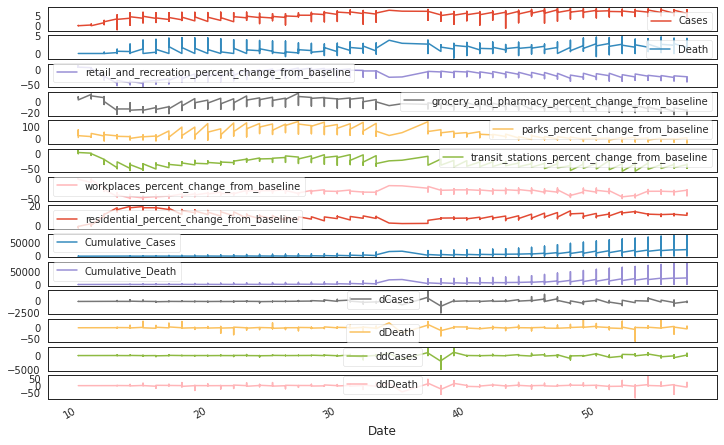

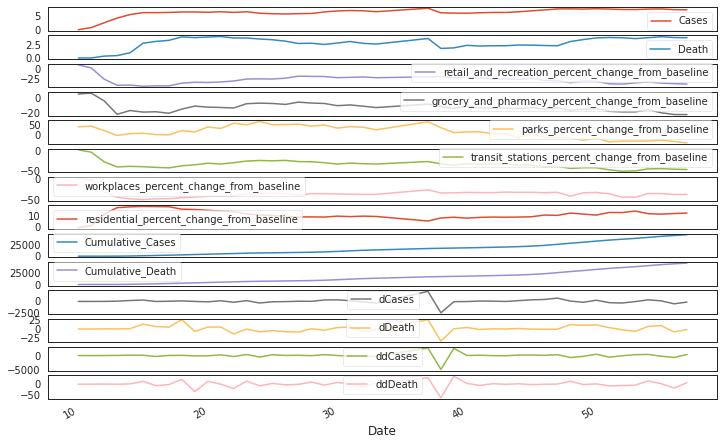

In [48]:
plot_merged_df(gap_df)
plot_merged_df(gap_df,'Baltimore','Maryland')

Remove week 33 to 39

In [49]:
def removeGap(gap_df):
    df = gap_df[(gap_df['Date']<33) | (gap_df['Date']>39)]
    display(df)
    return df

In [50]:
df = removeGap(gap_df)
df = df.dropna()
df.isna().sum()

,Date,State,County,Cases,Death,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Cumulative_Cases,Cumulative_Death,dCases,dDeath,ddCases,ddDeath
21,10,Alaska,Anchorage,0.000000,0.000000,10.857143,8.000000,8.714286,7.285714,1.000000,-0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22,10,Maryland,Baltimore,0.000000,0.000000,9.714286,5.428571,41.285714,2.857143,3.142857,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23,10,Missouri,St. Louis,0.133531,0.000000,15.000000,10.285714,77.428571,7.857143,3.000000,-1.714286,0.142857,0.142857,0.142857,0.000000,0.142857,0.000000
24,10,Virginia,Newport News,0.000000,0.000000,7.000000,7.714286,26.714286,0.142857,3.428571,-0.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25,10,Virginia,Norfolk,0.000000,0.000000,8.714286,4.857143,31.714286,2.428571,1.857143,-0.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,57,Missouri,St. Louis,7.879237,4.176583,-36.428571,-20.142857,-37.714286,-36.142857,-29.857143,11.428571,82555.285714,82555.285714,-225.428571,-4.285714,765.857143,22.857143
334,57,Virginia,Newport News,6.979810,2.410799,-26.428571,-17.571429,-30.714286,-38.000000,-27.285714,10.857143,9474.285714,9474.285714,43.142857,6.571429,-257.000000,6.142857
335,57,Virginia,Norfolk,6.790900,2.484907,-30.571429,-14.142857,-30.428571,-33.857143,-27.857143,11.428571,12518.000000,12518.000000,-107.571429,3.571429,-143.000000,4.000000
336,57,Virginia,Richmond,3.692445,0.251314,-39.571429,-18.857143,-31.857143,-39.857143,-42.142857,12.571429,1217.285714,1217.285714,-98.428571,0.285714,-101.857143,0.571429


Date                                                  0
State                                                 0
County                                                0
Cases                                                 0
Death                                                 0
retail_and_recreation_percent_change_from_baseline    0
grocery_and_pharmacy_percent_change_from_baseline     0
parks_percent_change_from_baseline                    0
transit_stations_percent_change_from_baseline         0
workplaces_percent_change_from_baseline               0
residential_percent_change_from_baseline              0
Cumulative_Cases                                      0
Cumulative_Death                                      0
dCases                                                0
dDeath                                                0
ddCases                                               0
ddDeath                                               0
dtype: int64

## Simple statistical time-series analysis

Directly apply https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9 to our 8 time series. No machine learning algorithm required. We wish to see if there is a leader-follower relationship between the time series.

Let 1-6 indicate our mobility data, 7-8 indicate case and death data

Maybe preprocessing to convert cases to logarithmic scale could help

for sanity check that method is reasonable, quantify synchrony between 7 and 8 as we expect death count to follow case count

quantify synchrony between 1-6 and 7-8

In [51]:
def calcPearson(df, before_or_after = 'before', col1 = 'Cases', col2 = 'Death', lag = 0):
    """Calculates Pearson r and p values given two columns"""
    if before_or_after=='before':
        d1 = df[(df['Date']<34)]
        d2 = df[(df['Date']<34)]
    else:
        d1 = df[(df['Date']>38)]
        d2 = df[(df['Date']>38)]
    r = 0
    p = 0
    l = len(pd.unique(df['County']))
    for county in pd.unique(df['County']):
        shifted_1 = d1[d1['County']==county][col1]
        shifted_2 = d2[d2['County']==county][col2].shift(lag)
        if lag>=0:
            county_r, county_p = stats.pearsonr(shifted_1[lag:],shifted_2[lag:])
        else:
            county_r, county_p = stats.pearsonr(shifted_1[:lag],shifted_2[:lag])
        r += county_r
        p += county_p
    return r/l, p/l

In [52]:
calcPearson(df)

(0.6111456864774777, 0.054443008201980385)

Cases are positively correlated with Death, no surprise but good to see sensible results.

In [68]:
def calcAllPearson(df, lag = 0):
    """Calculates Pearson r and p values for all pairs
    """
    places = ['retail_and_recreation','grocery_and_pharmacy','parks','transit_stations','workplaces','residential']
    places_percent_change = [place + '_percent_change_from_baseline' for place in places]
    x_cols = places_percent_change
    I = len(x_cols)
    y_cols = ['Cases','Death','dCases', 'dDeath','ddCases','ddDeath']
    J = len(y_cols)
    R, P = np.zeros([I,J]), np.zeros([I,J])
    for i in range(I):
        col1 = x_cols[i]
        for j in range(J):
            col2 = y_cols[j]
            r, p = calcPearson(df, "before",col1,col2,lag)
            R[i,j] = r
            P[i,j] = p
    return R, P

In [69]:
R, P = calcAllPearson(df)
display(R,P)

array([[-0.19721525, -0.16256229,  0.06355013, -0.07610304, -0.02238411,
         0.00278651],
       [-0.25384695, -0.14724055, -0.00877773, -0.09309998, -0.00197034,
        -0.01454743],
       [ 0.27333318,  0.09201319,  0.07178281, -0.07640285, -0.01447693,
         0.00533788],
       [-0.40674293, -0.24480366, -0.01052509, -0.08097086,  0.01562731,
         0.00587804],
       [-0.58749897, -0.37343782, -0.03228561, -0.10529451,  0.01364909,
        -0.01468118],
       [ 0.31933726,  0.23595323, -0.02955669,  0.10246651,  0.00531339,
         0.0045946 ]])

array([[0.46124505, 0.44999217, 0.57542691, 0.67918884, 0.89318427,
        0.87461868],
       [0.50589154, 0.36457294, 0.3997907 , 0.52654374, 0.88446438,
        0.77079854],
       [0.39666786, 0.34420399, 0.32627883, 0.51306472, 0.68724135,
        0.76454028],
       [0.17805771, 0.3756885 , 0.54719775, 0.57744238, 0.83289114,
        0.86048263],
       [0.02306136, 0.20172907, 0.74801307, 0.64963821, 0.91825101,
        0.91745626],
       [0.27009823, 0.37510538, 0.66767324, 0.63551468, 0.91655529,
        0.88555134]])

Residential activity is positively correlated with cases, whereas everything else is negatively correlated. This is the opposite of what is expected. However, the simple explanation is that government intervention occurs when cases are high and increases residential activity while decreasing other activity.

In [55]:
def calcTLCC(df, before_or_after, county = 'Anchorage', col1 = 'Cases', col2 = 'Death'):
    step = 7
    x = range(-int(step),int(step+1))
    rps = [calcPearson(df, before_or_after, col1, col2, lag) for lag in x]
    rs = [rp[0] for rp in rps]
    ps = [rp[1] for rp in rps]
    offset = np.ceil(len(rs)/2)-np.argmax(rs)
    f,ax=plt.subplots(figsize=(14,3))
    ax.plot(x, rs)
    ax.axvline(0,color='k',linestyle='--',label='Center')
    ax.axvline(x[np.argmax(rs)],color='r',linestyle='--',label='Peak synchrony')
    title_string = county + ' ' + before_or_after + '\n' + col1 + ' leads <> ' + col2 + ' leads'
    ax.set(title=title_string,ylim=[-1,1],xlim=[-step,step], xlabel='Offset',ylabel='Pearson r')
    plt.legend()
    
    f,ax=plt.subplots(figsize=(14,3))
    ax.plot(x, np.log(np.asarray(ps)))
    title_string = county + ' ' + before_or_after + '\n' + 'p value'
    ax.set(title=title_string,ylim=[-5,5],xlim=[-step,step], xlabel='Offset',ylabel='p value')
    return None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcPar

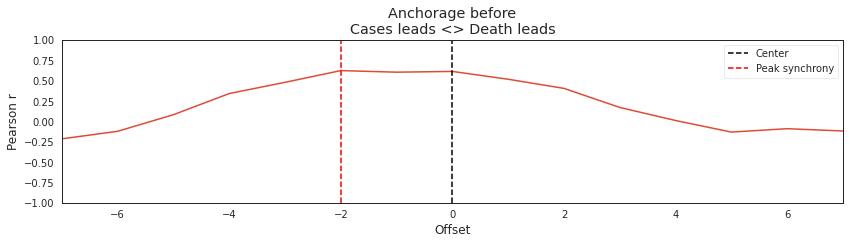

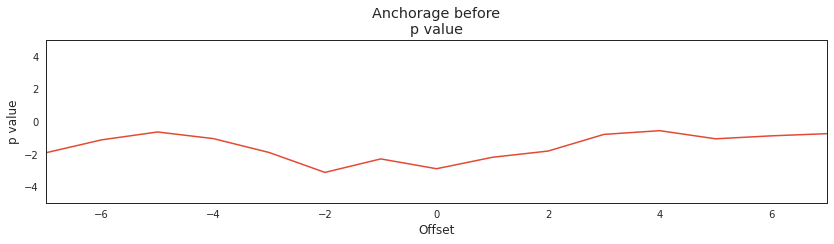

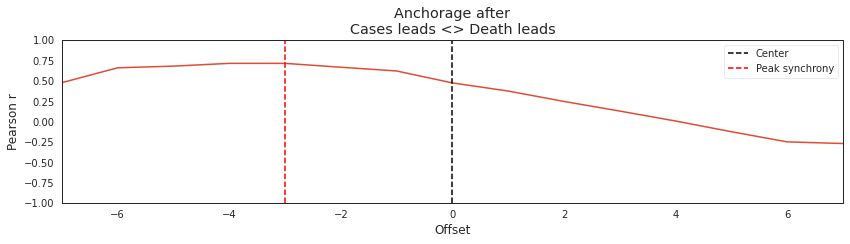

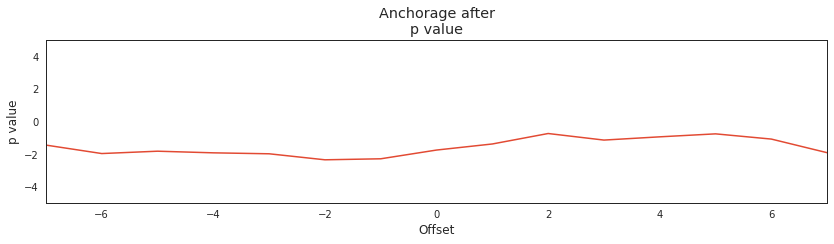

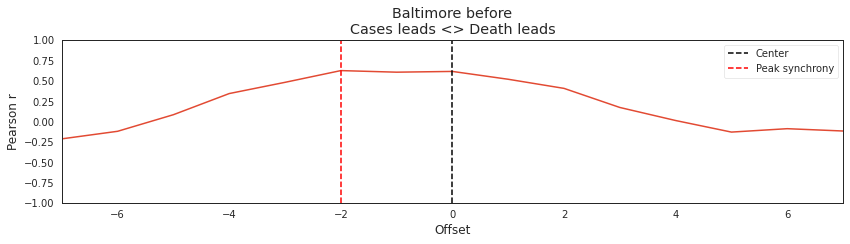

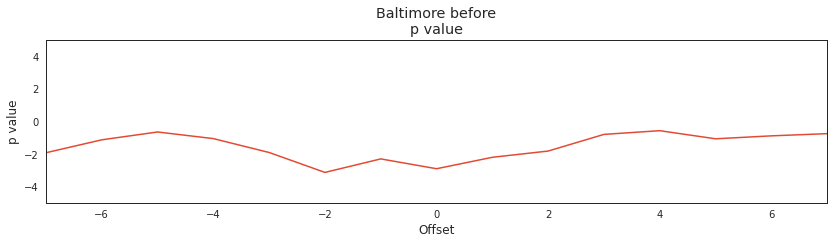

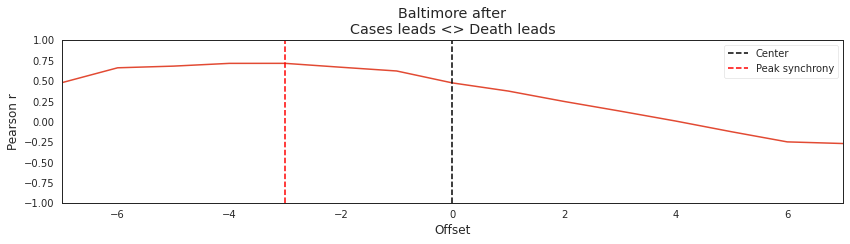

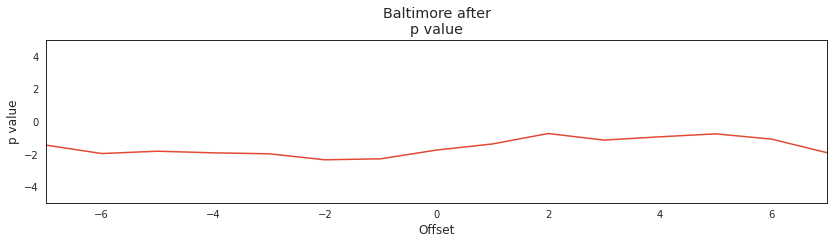

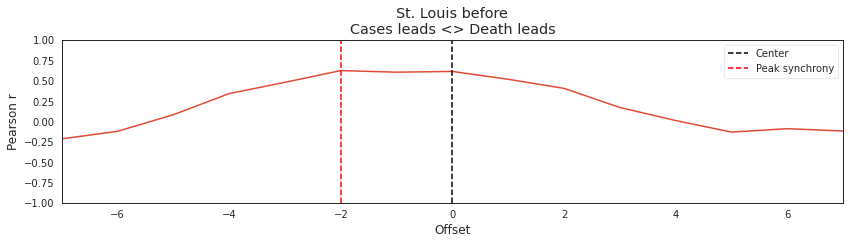

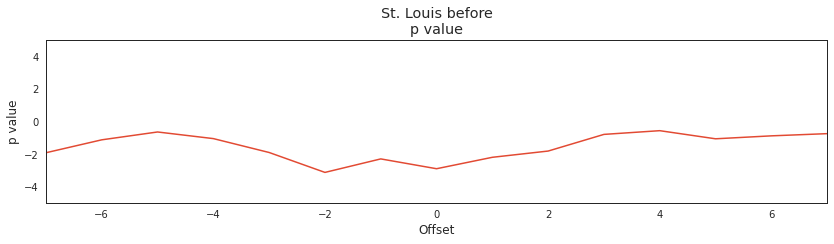

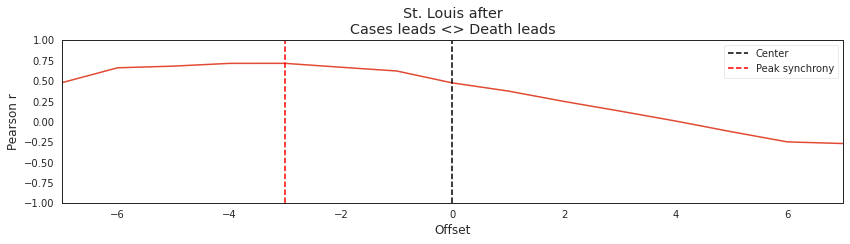

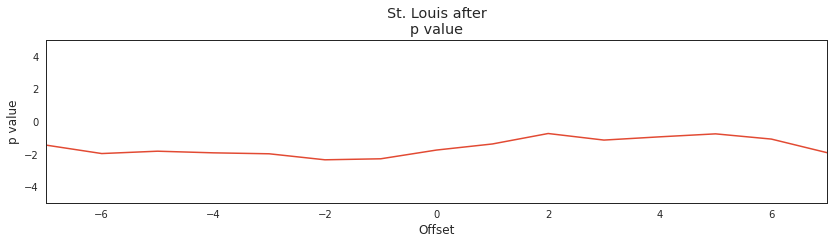

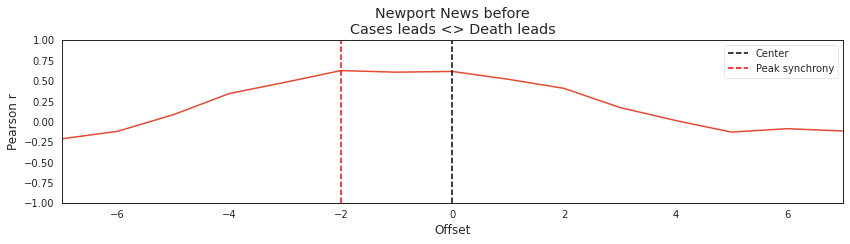

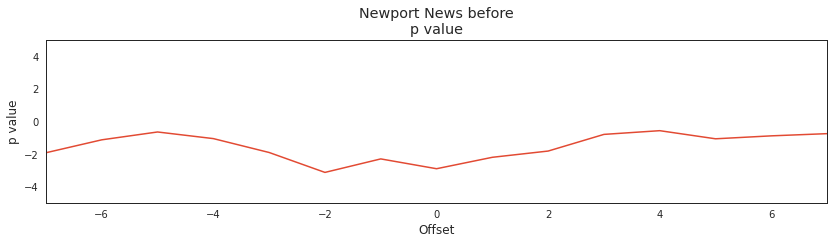

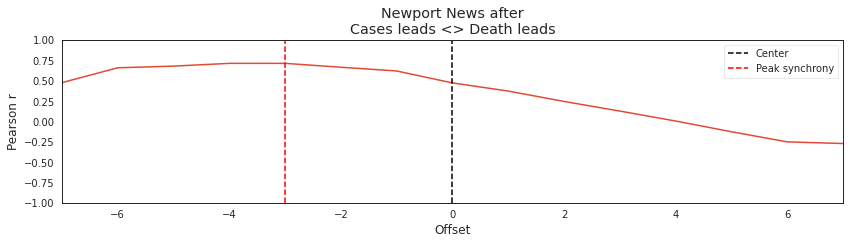

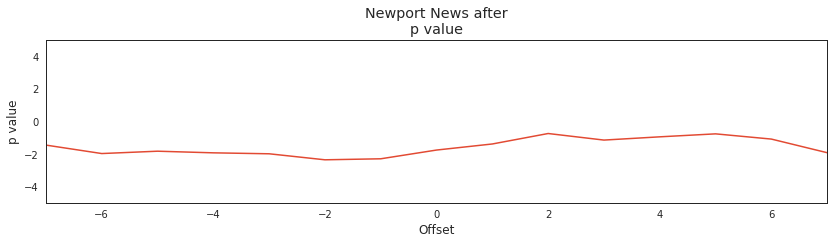

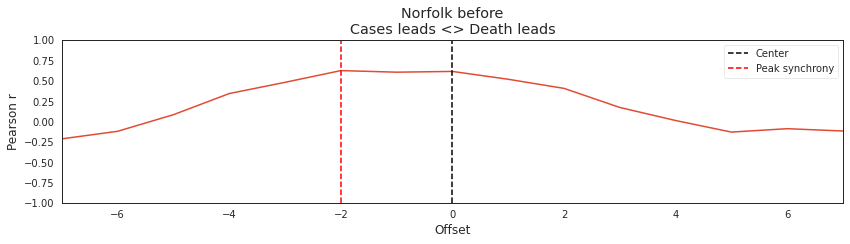

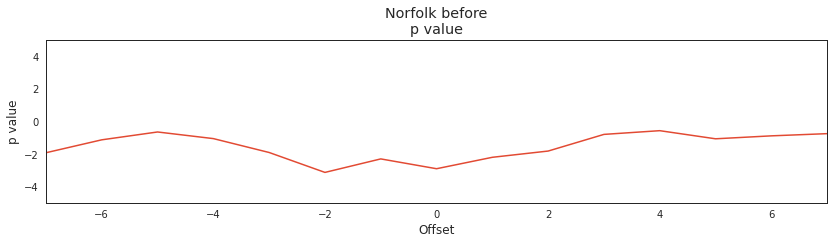

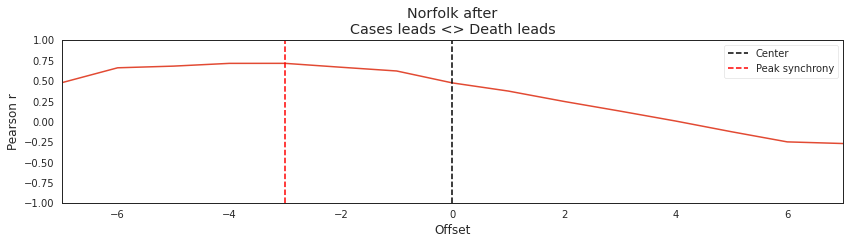

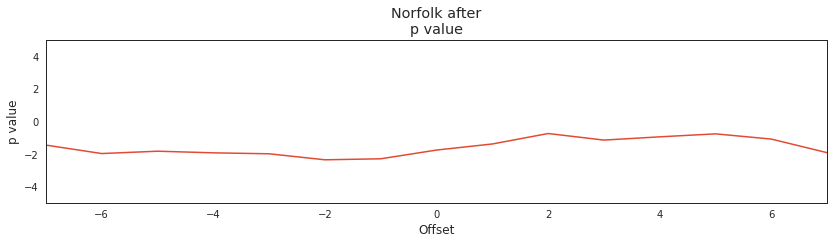

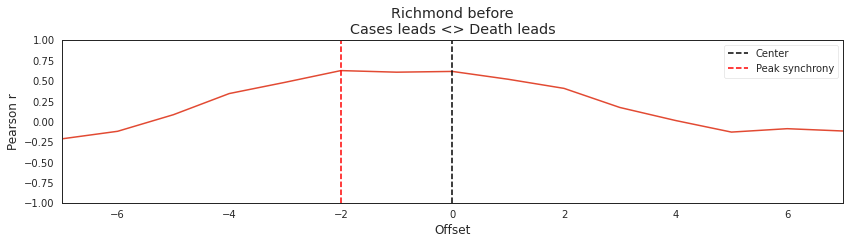

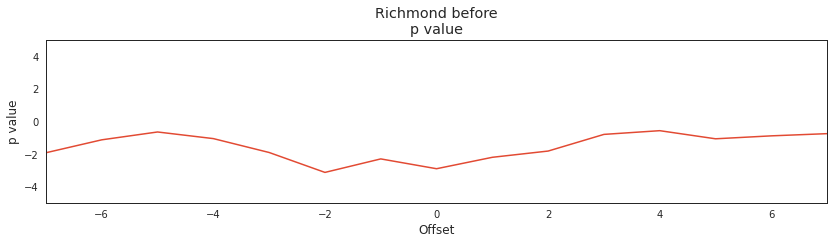

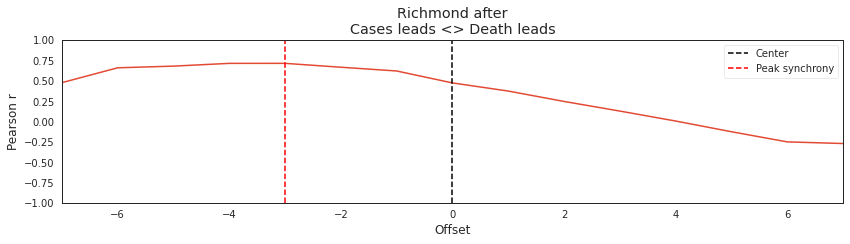

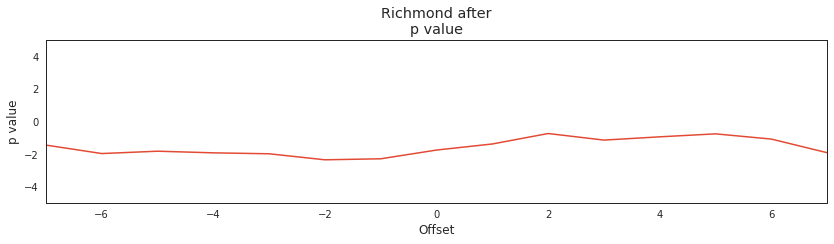

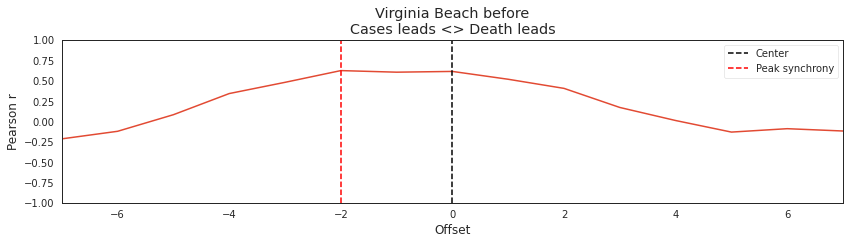

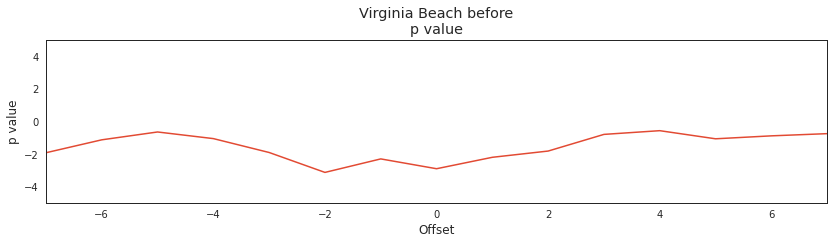

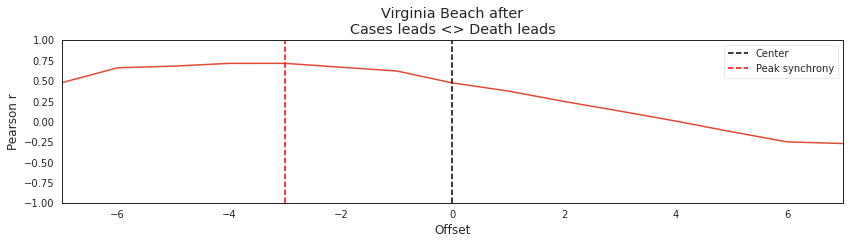

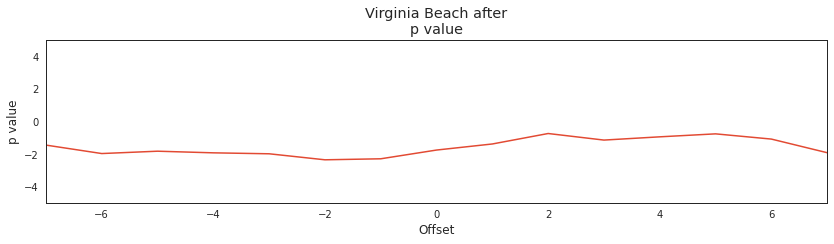

In [56]:
for county in df['County'].unique():
    calcTLCC(df, "before", county)
    calcTLCC(df, "after", county)

Not a rigorous analysis, but it does seem that deaths are lagging behind cases more slowly, so the condition is improving. What about mobility conditions?

In [57]:
def calcAllTLCC(df, county, places):
    """Calculates TLCC
    """
    places_percent_change = [place + '_percent_change_from_baseline' for place in places]
    x_cols = places_percent_change
    y_cols = ['Cases','dCases', 'ddCases']
    for col1 in x_cols:
        for col2 in y_cols:
            calcTLCC(df, "before", county, col1, col2)
            calcTLCC(df, "after", county, col1, col2)
    return None

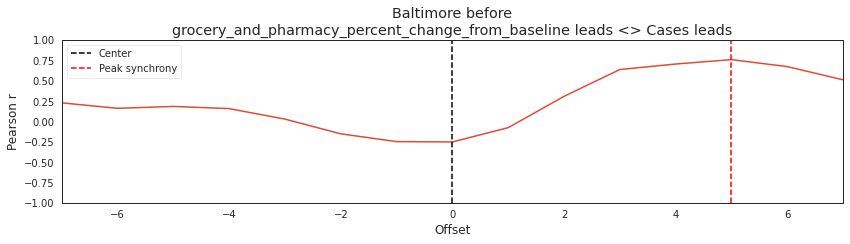

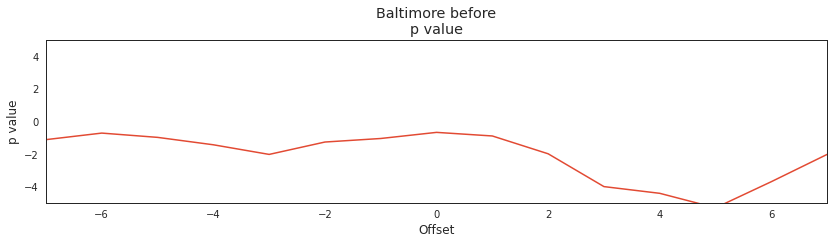

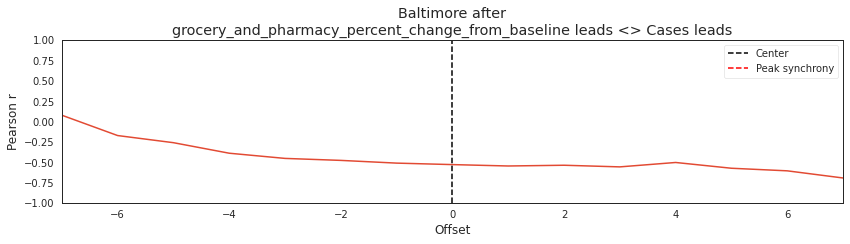

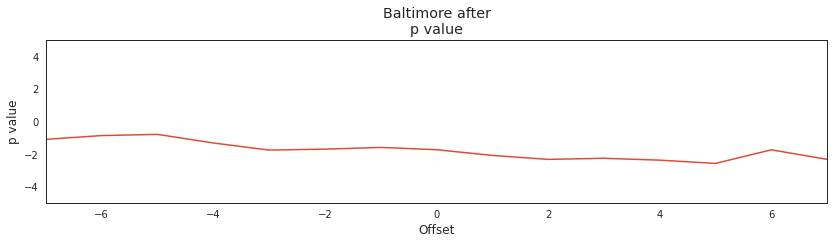

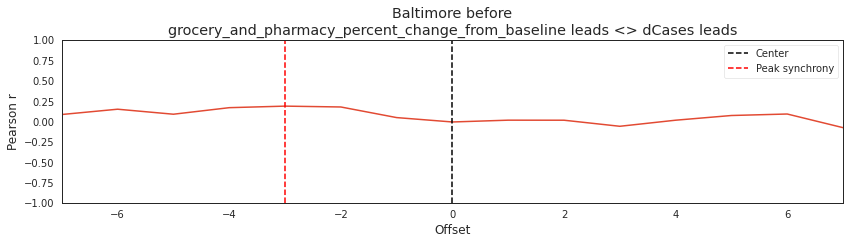

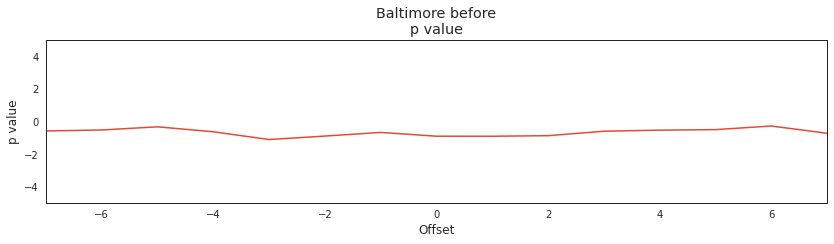

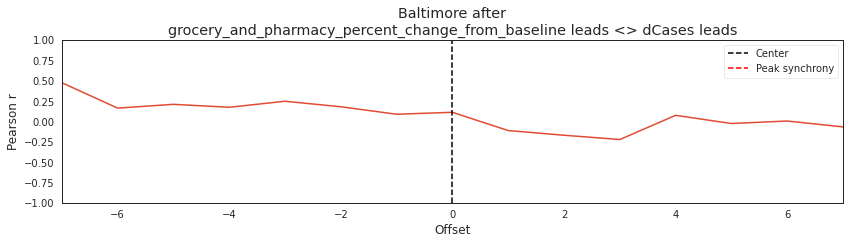

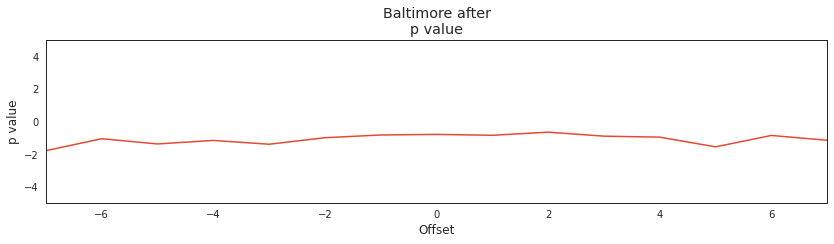

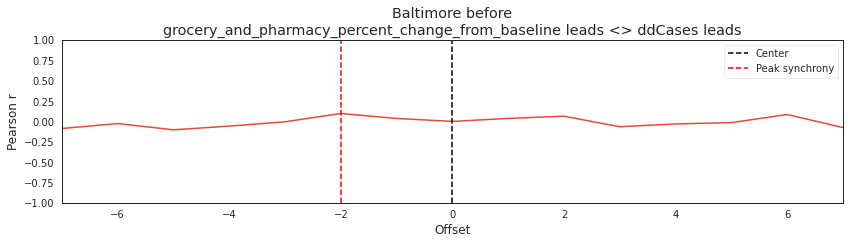

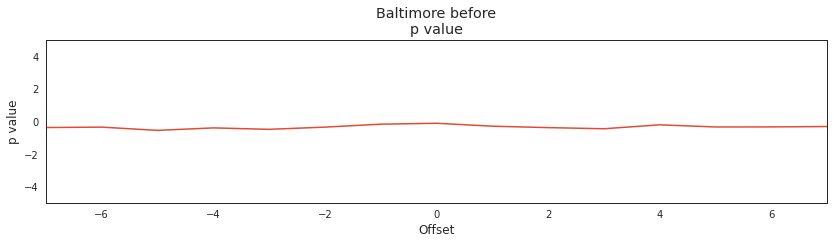

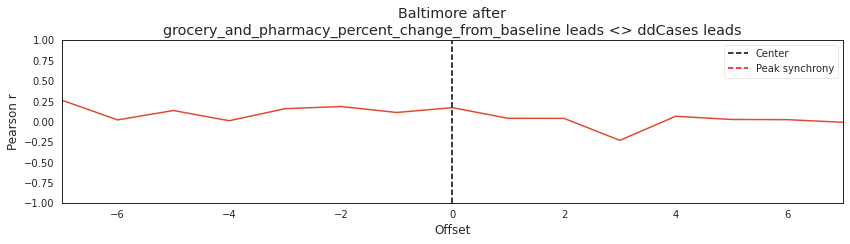

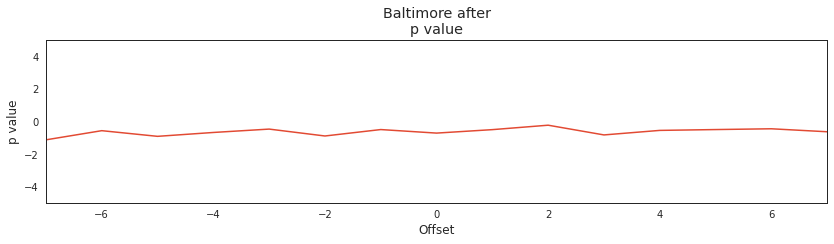

In [58]:
calcAllTLCC(df, 'Baltimore', ['grocery_and_pharmacy']) #['retail_and_recreation','grocery_and_pharmacy','parks','transit_stations','workplaces','residential']

Inconclusive evidence on mobility affecting cases.

## Machine Learning

Preprocess features by batching over 7 days (to remove intra-weekly fluctuations)

Features: (for example take $\lambda \in [5,10]$ days as expected lag for cases, $\gamma$ = 7 days as expected batch size (since cases have cyclic behavior that is weekly))

COVID new cases in previous period $nc_{0} = \sum_{\tau \in (t-\gamma, t]} c_{\tau}$, $nc_{k} = \sum_{\tau \in (t+(k-1)\gamma, t+k\gamma]} c_{\tau}$

COVID new cases delta in previous period $d_{0} = nc_{0}-nc_{-1}$, $d_{k} = nc_{k} - nc_{k-1}$

COVID new cases change in delta $dd_{0} = d_{0} - d_{-1}$, $dd_{k} = d_{k} - d_{k-1}$

Same as above for COVID new deaths.

For mobility data, delta and delta change probably not as important so only do mobility cases in previous period

Government policy type

Response Var (possibilities):

Given information at time $<t$

COVID new cases in the next period $[t+\lambda,t+\lambda+\gamma]$ where $\lambda$ = expected lag, $\gamma$ = period size

COVID new cases delta (diff between new cases next period and previous period)

COVID new cases change in delta (diff between change in new cases next period and previous period)

In [75]:
def preprocess_for_ml(new_df):
    """Preprocesses the dataframe so that it can be read into the machine learning models
    Input df columns:
        state
        cases
        deaths
        mobility 1-6
    Return values:
        x_data = dataframe containing relevant columns, data placed into buckets of 7 days
        y_data = dataframe containing only response variable, data placed into buckets of 7 days
    Relevant columns for x_data:
    For each t, we have a row that contains:
        state
        cases in days (t-7,t]
        dcases in days (t-7,t]
        ddcases in days (t-7,t]
        deaths in days (t-7,t]
        ddeaths in days (t-7,t]
        dddeaths in days (t-7,t]
        mobility_1 in days (t-7,t]
        mobility_2 in days (t-7,t]
        ...
        mobility_6 in days (t-7,t]
        
    Relevant response variables for y_data (pick one of the two) for tau\in [5,10]:
        cases in days [t+tau,t+tau+7)
        deaths in days [t+tau,t+tau+7)
    """
    # use dataframe with bucket data
    shifted_data = new_df[:]
    for county in pd.unique(new_df['County']):
        idx = (new_df['County']==county)
        shifted_data.loc[idx, 'dCases'] = new_df.loc[idx,'Cases'].diff()
        shifted_data.loc[idx,'dDeath'] = new_df.loc[idx,'Death'].diff()
        shifted_data.loc[idx, 'ddCases'] = shifted_data.loc[idx,'dCases'].diff()
        shifted_data.loc[idx, 'ddDeath'] = shifted_data.loc[idx,'dDeath'].diff()
        shifted_data.loc[idx, 'Cases_s'] = shifted_data.loc[idx,'Cases'].shift(-1)
        shifted_data.loc[idx, 'Death_s'] = shifted_data.loc[idx,'Death'].shift(-1)
        shifted_data.loc[idx, 'Cases_response'] = shifted_data.loc[idx, 'Cases_s'].sub(shifted_data.loc[idx, 'Cases'], axis = 0)
        shifted_data.loc[idx, 'Death_response'] = shifted_data.loc[idx, 'Death_s'].sub(shifted_data.loc[idx, 'Death'], axis = 0) 
    one_hot_county = pd.get_dummies(shifted_data['County'])
    one_hot_state = pd.get_dummies(shifted_data['State']) 
    # Drop column County as it is now encoded
    shifted_data = shifted_data.drop(['County', 'State'],axis = 1)
    # Join the encoded df
    shifted_data = shifted_data.join(one_hot_county)
    shifted_data = shifted_data.join(one_hot_state)

    shifted_data = shifted_data.dropna()

    y_data = shifted_data.filter(['Date','County','Cases_response', 'Death_response'], axis=1)
    x_data = shifted_data.drop(['Cases_response', 'Death_response'], axis=1)
    
    return x_data, y_data

In [76]:
x_data, y_data = preprocess_for_ml(new_df)
display(x_data)
display(y_data)

,Date,Cases,Death,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Cumulative_Cases,Cumulative_Death,dCases,dDeath,ddCases,ddDeath,Cases_s,Death_s,Anchorage,Baltimore,Newport News,Norfolk,Richmond,St. Louis,Virginia Beach,Alaska,Maryland,Missouri,Virginia
35,12,1.488077,0.000000,-24.571429,8.714286,22.142857,-18.285714,-23.000000,10.000000,3.857143,3.857143,1.131402,0.000000,0.774727,0.000000,3.367296,0.251314,1,0,0,0,0,0,0,1,0,0,0
36,12,2.564949,0.356675,-25.714286,-3.857143,22.285714,-27.285714,-30.857143,11.714286,13.142857,13.142857,1.802809,0.356675,1.040669,0.356675,4.326967,0.451985,0,1,0,0,0,0,0,0,1,0,0
37,12,2.618438,0.356675,-34.000000,10.714286,-21.714286,-27.714286,-28.857143,11.000000,14.142857,14.142857,1.791759,0.356675,1.098612,0.356675,5.364640,1.189584,0,0,0,0,0,1,0,0,0,1,0
38,12,0.538997,0.133531,-24.285714,5.000000,29.142857,-24.857143,-23.285714,10.142857,0.714286,0.714286,0.538997,0.133531,0.538997,0.133531,2.164964,0.619039,0,0,1,0,0,0,0,0,0,0,1
39,12,0.538997,0.000000,-24.571429,1.000000,15.571429,-34.428571,-22.714286,9.000000,1.285714,1.285714,0.087011,0.000000,-0.364974,0.000000,2.148434,0.000000,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,56,7.961121,4.240298,-32.428571,-16.714286,-21.142857,-32.428571,-31.000000,10.714286,79914.428571,79914.428571,-0.296931,-0.329984,-0.279898,-0.766244,7.879237,4.176583,0,0,0,0,0,1,0,0,0,1,0
327,56,6.938839,1.519826,-24.000000,-13.571429,-10.857143,-35.857143,-28.571429,10.571429,8400.571429,8400.571429,0.343839,0.098440,0.265033,0.132342,6.979810,2.410799,0,0,1,0,0,0,0,0,0,0,1
328,56,6.905037,2.131627,-27.857143,-11.142857,-15.571429,-31.142857,-28.285714,10.142857,11629.285714,11629.285714,0.036171,-0.049597,-0.066009,-0.225488,6.790900,2.484907,0,0,0,1,0,0,0,0,0,0,1
329,56,4.931386,0.000000,-36.428571,-17.285714,-13.428571,-36.285714,-39.857143,11.428571,1178.142857,1178.142857,0.025054,-0.251314,-0.281839,0.036368,3.692445,0.251314,0,0,0,0,1,0,0,0,0,0,1


,Date,Cases_response,Death_response
35,12,1.879219,0.251314
36,12,1.762018,0.095310
37,12,2.746202,0.832909
38,12,1.625967,0.485508
39,12,1.609438,0.000000
...,...,...,...
326,56,-0.081884,-0.063716
327,56,0.040972,0.890973
328,56,-0.114137,0.353279
329,56,-1.238941,0.251314


In [61]:
def preprocess_for_ml2(merged_df):
    """Similar to preprocess_for_ml except now we explore the effect of government policies
    Input df columns:
        state
        cases
        deaths
        mobility 1-6
    Return values:
        x_data = dataframe containing relevant columns, data placed into buckets of 7 days
        y_data = dataframe containing only response variable, data placed into buckets of 7 days
    Relevant columns for x_data:
    For each t (in which a government policy or government policy announcement occurs, may restrict to only impactful policies), we have a row that contains:
        state
        cases in days (t-7,t]
        dcases in days (t-7,t]
        ddcases in days (t-7,t]
        deaths in days (t-7,t]
        ddeaths in days (t-7,t]
        dddeaths in days (t-7,t]
        mobility_1 in days (t-7,t]
        mobility_2 in days (t-7,t]
        ...
        mobility_6 in days (t-7,t]
        type of policy
        duration of policy
        is_announcement
        is_action
        
    Relevant response variables for y_data (pick one of the two) for tau\in [5,10]:
        cases in days [t+tau,t+tau+7)
        deaths in days [t+tau,t+tau+7)
    """
    x_data = None
    y_data = None
    return x_data, y_data

In [86]:
#Cross Validation
from sklearn.model_selection import cross_val_score
def cross_validation (x_data,y_data):
  clf = sklearn.svm.SVR()
  scores=cross_val_score(clf,x_data,y_data,cv=5)
  np.mean(scores)
  print(scores)
    
#Splitting Dataset
def split_dataset(ts):
  x_data = df[['attributes']]
  y_data = df[['target_variable']]
  x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=ts)
  print("x_train ({0}):\n{1}".format(len(x_train), x_train.head()))
  print("\ny_train ({0}):\n{1}".format(len(y_train), y_train.head()))
  print("\nx_test ({0}):\n{1}".format(len(x_test), x_test.head()))
  print("\ny_test ({0}):\n{1}".format(len(y_test), y_test.head()))

#To find the order of the polynomial
def order_select(n,reg_model,x_train,y_train,x_test,y_test):
  rsquare_test =[]
  order= range(1,n+1)
  for n in order:
    pr= PolynomialFeatures(degree=n)
    x_train_pr = pr.fit_transform(x_train)
    x_test_pr = pr.fit_transform(x_test)
    reg_model.fit(x_train_pr,y_train)
    rsquare_test.append (lr.score(x_test_pr,y_test))
    
#to perform grid search
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
def grid_search (x_data,y_data,k):
  params= [{'alpha':[0.001,0.01,0.1,1,10,100]}]
  RR=Ridge()
  grid= GridSearchCV(RR,params,cv=k)
  grid.fit(x_data,y_data)
  grid.best_estimator_
  scores=grid.cv_results_
  scores['mean_test_score']

In [96]:
x_data = preprocess_for_ml(new_df)[0]
y_data = preprocess_for_ml(new_df)[1]
y_data = y_data.filter(['Death_response'], axis=1).values.ravel()
cross_validation(x_data, y_data)
split_dataset(20)

[-0.03113296 -0.1465462   0.00281981  0.00306772 -0.2499008 ]


KeyError: ignored